# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Отличная практика - расписывать цель и основные этапы своими словами (этот навык очень поможет на фильнальном проекте). Хорошо было бы добавить ход и цель исследования. Вот мой личный пример: 
    
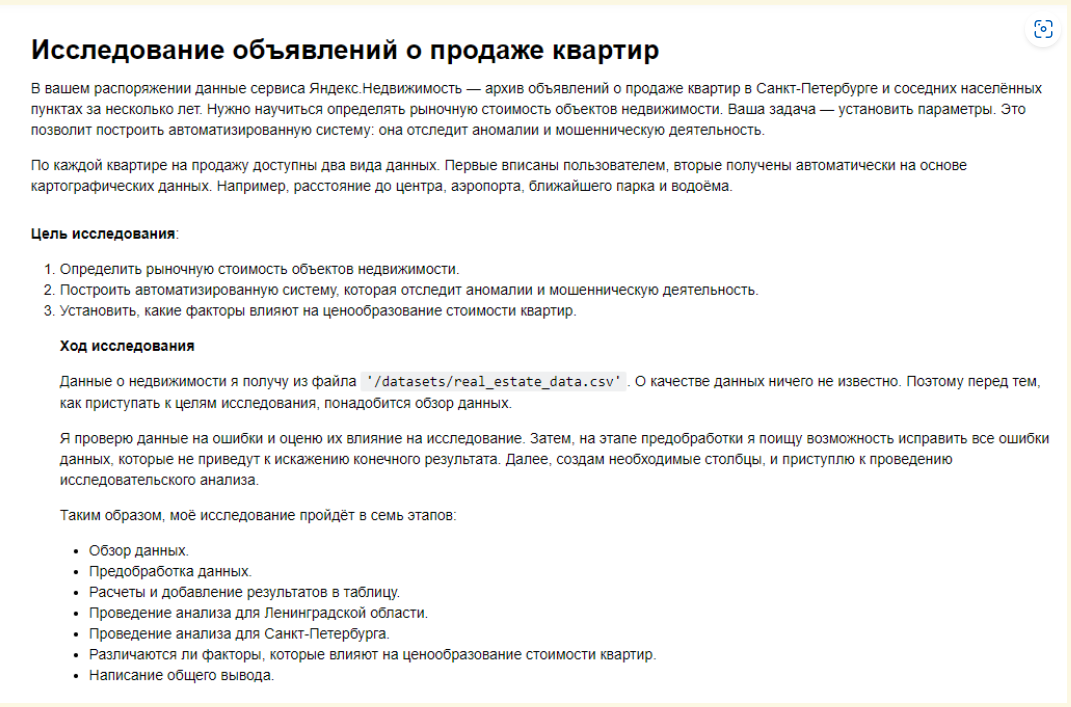
</div>

## Откройте файл с данными и изучите общую информацию. 

Для начала импортируем все необходимые библиотеки и сохраним данные из файла в переменную `data`:

In [1]:
import pandas as pd
import matplotlib as pt
import statistics as st
import numpy as np
import seaborn as sb

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

Рассмотрим общую информацию о таблице с помощью метода `.info()` : 

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

И выведем первые 5 строк таблицы:

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


И наконец рассмотрим общую гистограмму для всех числовых столбцов:

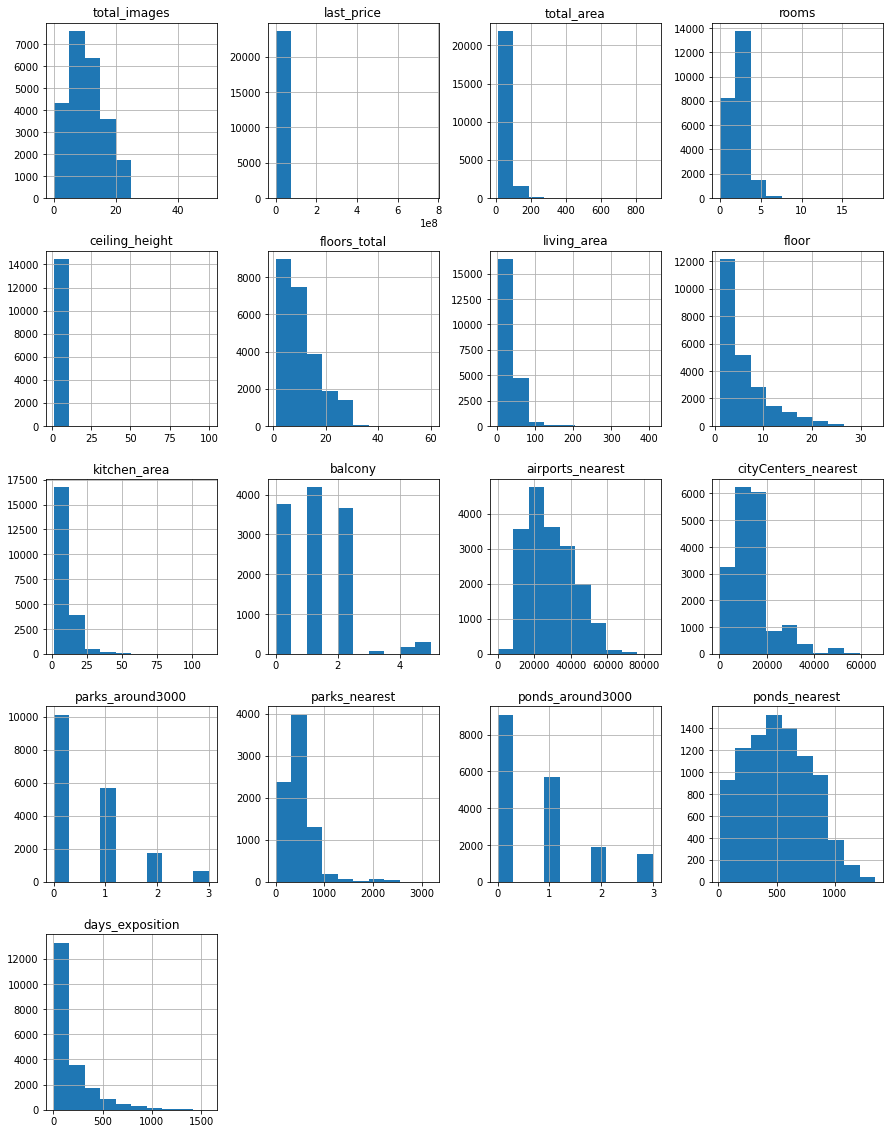

In [4]:
data.hist(figsize=(15, 20));

## Предобработка данных

### Поиск и изучение пропущенных значений в таблице

Для начала посмотрим в каких столбцах есть пропуски и сколько их:

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

И взглянем также сколько процентов от общего объема данных составляют пропуски:

In [6]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Большая часть столбцов имеет пропуски которые могут быть совершены по разным причинам. Заполним пропущенные значения там где это возможно. Начнем со столбца `is_apartment` - скорее всего если пользователь не указал никакого значения, то квартира не является апартаментами. Аналогичное касается столбца `balcony`. Тогда в этих столбцах заполним пропуски значением `False`, так как столбцы содержат данные типа `bool`. Строк где пропущено значение `locality_name` всего 49, поэтому можно исключить их из таблицы, ввиду того что они составлят меньше 1% от общих данных и не смогут сильно испортить статистику.

In [6]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data = data.dropna(subset = ['locality_name'])

Проверим что в данных столбцах не осталось пропусков:

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

Пропусков и правда нет. Теперь рассмотрим столбцы `parks_around3000` и `ponds_around3000`. Заметим что у данных столбцов совпадает количество пропусков, возможно они допущены в одних и тех же строчках. Проверим это, сделав срез таблицы по тем строкам, где пустое значение в выбранных столбцах и выведем количество пропусков на экран. Срез поместим в переменную `data_lost`

In [8]:
data_lost = data.query('parks_around3000.isna() and ponds_around3000.isna()')
data_lost.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          2569
floors_total              10
living_area              622
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             713
balcony                    0
locality_name              0
airports_nearest        5510
cityCenters_nearest     5510
parks_around3000        5510
parks_nearest           5510
ponds_around3000        5510
ponds_nearest           5510
days_exposition          864
dtype: int64

Предположение оказалось верным и даже задело несколько других столбцов. Можно заметить что в выбранных квартирах нет никакой информации об аэропорте, центре города, парках и водоемах. Можно предположить что все выбранные квартиры находятся в небольших поселениях, которые не являются городами, следовательно у них нет центра, а также нет аэропорта, парков и водоемов. Можно проверить это предположение рассмотрев все населенные пункты в которых находятся выбранные квартиры:

In [9]:
data_lost['locality_name'].unique()

array(['городской посёлок Янино-1', 'посёлок Мурино', 'Сертолово',
       'деревня Кудрово', 'Коммунар',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кировск',
       'деревня Новое Девяткино', 'Санкт-Петербург',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'деревня Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Сясьстрой', 'деревня Старая', 'деревня Лесколово',
       'посёлок Новый Свет', 'Сланцы', 'село Путилово', 'Ивангород',
       'Мурино', 'Шлиссельбург', 'Никольское', 'Сосновый Бор',
       'поселок Новый Свет', 'деревня Оржицы', 'деревня Кальтино',
 

Предположение вновь оказалось верным! Все населенные пункты являются поселками или деревнями, поэтому в них нет аэропорта, водоема или же парка. Для будущих исследований, связанных с водоемами, парками и аэропортами эти данные не стоит включать в выборку. Заполнить пропуски для столцбов `parks_around3000` и `ponds_around3000` можно нулями, так как столбцы обозначают количество объектов в радиусе 3км, которых, как мы поняли ровно ноль:

In [10]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

Проверим, возможно для некоторых квартир где в радиусе 3км есть парк или водоем не были записаны расстояния до ближайших:

In [11]:
print(data.query('ponds_around3000 !=0 and ponds_nearest.isna()').shape[0])
print(data.query('parks_around3000 !=0 and parks_nearest.isna()').shape[0])

0
0


Получается если в радиусе 3км от квартиры есть водоем или парк, расстояние до ближайшего точно записано. Все оставшиеся пропуски тяжело будет заполнить значениями которые будут логичными.

### Типы данных

Еще раз рассмотрим общую информацию о таблице:

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Необходимо поменять тип данных в следующих столбцах:
- `first_day_exposition` на формат datetime
- `balcony`, `floors_total`, `floor`,  на формат integer
- `floors_total`, `parks_around3000` , `ponds_around3000`, `days_exposition` на integer 

Сделаем это с помощью методов `astype()`, `to_datetime()` : 

In [13]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['balcony'] = data['balcony'].astype('int', errors = 'ignore')
data['floors_total'] = data['floors_total'].astype('int', errors = 'ignore') #добавление параметра ignore, 
                                                                             #так как присутствуют пропуски
data['floor'] = data['floor'].astype('int', errors = 'ignore')
data['floors_total'] = data['floors_total'].astype('int', errors = 'ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int', errors = 'ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors = 'ignore')
data['days_exposition'] = data['days_exposition'].astype('int', errors = 'ignore')

### Обработка неявных дубликатов

Рассмотрим уникальные значения столбца `locality_name`

In [14]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Попробуем избавиться от всех возможных дубликатов следующим способом - почти везде перед самим названием населенного пункта идет обозначение типа - поселок, деревня, поселок городского типа и так далее. И часть дубликатов скрывается как раз из за ошибки в типах населенных пунктов. Допустим городской поселок Янино-1 имеет две записи, в них поселок записан 2 разными способами: "поселок" и "посёлок". А уникальных значений достаточно много чтобы перебирать их вручную. Тогда попробуем разбить строку по разделителю в виде пробела. И каждое название населенного пункта заменим на последнее значение в полученном списке. К примеру "городской поселок Янино-1" поменять на "Янино-1". Таким образом от большей части неявных дубликатов получится избавиться. Также воспользуемся приведением к нижнему регистру на случай еслии некоторые названия начинаются с прописной буквы. 

In [15]:
for i in data['locality_name'].unique().tolist():
    data.loc[(data['locality_name'] == i), 'locality_name'] = i.split()[-1]
data['locality_name'] = data['locality_name'].str.lower()

Теперь посмотрим на количество явных дубликатов:

In [16]:
data.duplicated().sum()

0

Таблица не имеет явных дубликатов, можем двигаться дальше!

### Удаление аномальных значений

Рассмотрим столбцы связанные с: размерами квартир - это их площади, а также размерами домов. Начнем с квартир, первым будет солбец `ceiling_height`. Посмотрим на все уникальные значения в этом столбце:

In [17]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Получили достаточно много аномальных значений. Скорее всего при указании высоты потолков забывали добавить запятую в нужном месте и высота получалась в 10 раз больше. Поэтому во всех строках где указана высота потолка больше 15 метров, заменим высоту на значение в 10 раз меньше прежнего:

In [18]:
for i in data['ceiling_height']:
    if i > 15: 
        data.loc[(data['ceiling_height'] == i), 'ceiling_height'] /= 10

Теперь проверим столбец `floors_total`:

In [19]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

Можно заметить несколько аномальных значений - 60, 52, 37, 36, 35, 34, 33. Посмотрим сколько квартир имеют такие значения:

In [20]:
print(data.query('floors_total == 60 or floors_total == 52 or floors_total == 37 \
                 or floors_total == 36 or floors_total == 35 or floors_total == 34 or floors_total == 33').shape[0])

32


Таких значений в таблице совсем мало так что мы можем их отбросить для того чтобы статистика была более корректная:

In [21]:
data = data.loc[(data['floors_total'] != 60)&(data['floors_total'] != 52)\
                &(data['floors_total'] != 37)&(data['floors_total'] != 36)\
                &(data['floors_total'] != 35)&(data['floors_total'] != 34)\
                &(data['floors_total'] != 33), :]

Теперь рассмотрим столбец `rooms` - количество комнат в квартире:

In [22]:
print(data['rooms'].unique())

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]


Квартиры в которых есть 4 или 5 комнат еще можно представить, но когда комнат 8 или тем более 16, это вызывает подозрение, похоже на аномальные значения. Посмотрим сколько вообще квартир в которых больше 5 комнат.

In [23]:
print(data[data['rooms'] > 9].shape[0])

11


Всего лишь 11 квартир из почти 23000. Проще будет отбросить эти значения:

In [24]:
data = data.loc[(data['rooms'] <= 5), :]

Также присутствуют строки с 0 комнат. Скорее всего это небольшие квартиры-студии. Можно отнести их к однокомнатным и присвоить значение 1 в столбце `rooms`:

In [25]:
data.loc[(data['rooms'] == 0),'rooms'] = 1

**Вывод:** Таблица приведена в состояние, пригодное для дальнейшего анализа. Были найдены и по возможности удалены пропуски, исправлены типы данных на нужные, обработаны дубликаты и аномальные значения.

## Посчитайте и добавьте в таблицу новые столбцы

In [26]:
#добавим столбец weekday - день недели публикации объявления:
data['weekday'] = data['first_day_exposition'].dt.weekday

#цена одного квадратного метра - metre_price : 
data['metre_price'] = data['last_price']/data['total_area']

#месяц публикации month - месяца обозначаются номерами от 1 до 12 - от января до декабря
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#год публикации объявления year:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#тип этажа квартиры type_floor. создаем функцию которая в зависимости от этажа выдает его тип:
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(type_floor, axis=1)

#расстояние до центра города в км:
data['city_centre_km'] = (data['cityCenters_nearest']/1000).round()

Чтобы убедиться что все новые столбцы введены корректно выведем первые 10 строк таблицы:

In [27]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,weekday,metre_price,month,year,floor_type,city_centre_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,482.0,2,755.0,NaN,3,120370.370370,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,False,...,NaN,0,NaN,81.0,1,82920.792079,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,False,...,90.0,2,574.0,558.0,3,92785.714286,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3,234.0,424.0,4,408176.100629,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,112.0,1,48.0,121.0,1,100000.000000,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,False,...,NaN,0,NaN,55.0,0,95065.789474,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.60,6,False,...,NaN,0,NaN,155.0,3,99195.710456,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,NaN,22,False,...,NaN,0,NaN,NaN,3,110544.692737,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,False,...,NaN,0,NaN,189.0,2,87454.764777,5,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,NaN,0,NaN,289.0,6,88524.590164,2,2017,другой,15.0


**Вывод:** Были добавлены новые столбцы для дальнейшего анализа данных:
- weekday - день недели публикации объявления
- metre_price - цена одного квадратного метра
- month - месяц публикации 
- year - год публикации объявления
- type_floor - тип этажа квартиры
- city_centre_km - расстояние до центра города в км

## Проведите исследовательский анализ данных

### Распределение данных

Рассмотрим распределение общей площади по размеру:

<AxesSubplot:>

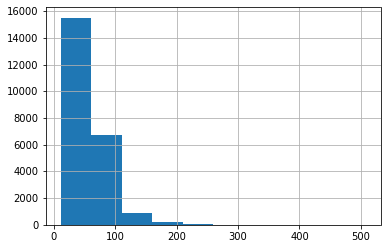

In [28]:
data['total_area'].hist()

Сделаем график более детальным и рассмотрим его на промежутке от 0 до 250 - чтобы понять как распределяются основные значения (так как квартир с площадью более 250 очень мало и на графике их почти не видно)

<AxesSubplot:>

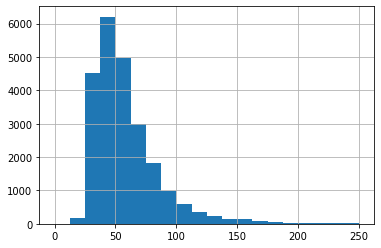

In [29]:
data['total_area'].hist(bins = 20, range = (0,250))

Теперь видно что распределение напоминает нормальное распределение Гаусса - то есть квартир с небольшой площадью почти нет, больше всего квартир со средней площадью (от 40 до 70 кв.м.) и дальше чем больше площадь тем меньше таких квартир. Значит с данными все в порядке, нет никакой критической ошибки или аномальных значений.

Посмотрим теперь на распределение по жилой площади:

<AxesSubplot:>

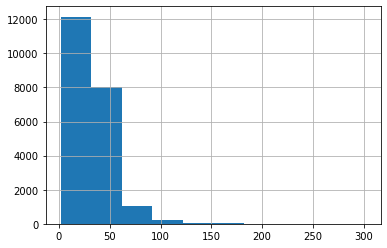

In [30]:
data['living_area'].hist()

<AxesSubplot:>

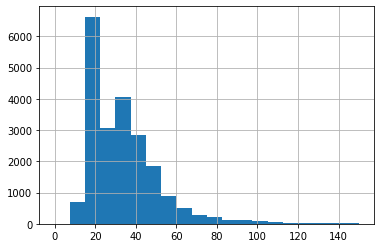

In [31]:
#чуть более детально:
data['living_area'].hist(bins = 20, range = (0,150))

В этот раз есть небольшое отличие от классического распределения Гаусса. Тут заметен "провал" в интервале от 20 до примерно 30 кв.м. Однако во всем остальном график похож на нормальное распределение.

Посмотрим на площадь кухни:

<AxesSubplot:>

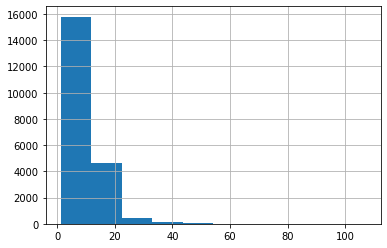

In [32]:
data['kitchen_area'].hist()

<AxesSubplot:>

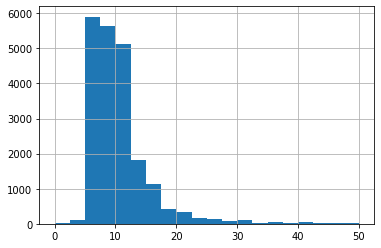

In [33]:
#увеличим масштаб:

data['kitchen_area'].hist(bins = 20, range = (0,50))

Распределение все то же, данные в порядке.

Теперь цена объекта. Тут сразу стоит отметить, что разброс значений стоит брать от 100 000 до 20 млн рублей, так как 
это основной разброс цен на квартиры:

<AxesSubplot:>

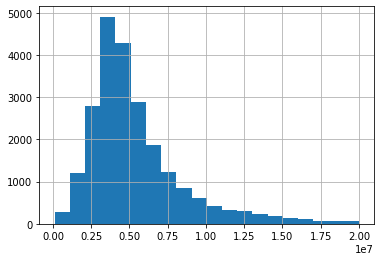

In [34]:
data['last_price'].hist(bins = 20, range = (100000, 20000000))

Данные в порядке, можем идти дальше

Теперь количество комнат:

<AxesSubplot:>

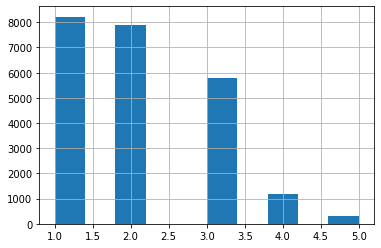

In [35]:
data['rooms'].hist()

Для данного параметра сложно строить гистограмму так как мы решили что большая часть квартир имеет от 1 до 5 комнат. Поэтому анализировать полученную гистограмму, можно лишь сказать что большая часть квартир имеет 1 или 2 комнаты, 3х-комнатных квартир поменьше, а больших квартир с 4 и 5 комнатами совсем мало.

Перейдем к рассмотрению высоты потолков:

<AxesSubplot:>

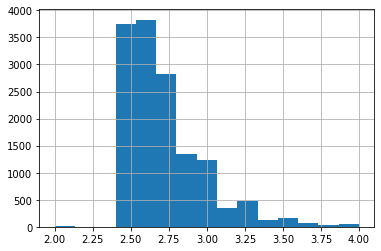

In [36]:
data['ceiling_height'].hist(bins = 15, range = (2,4))

Получили распределение Пуассона

Построим гистограмму для этажей:

<AxesSubplot:>

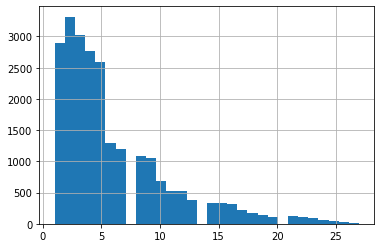

In [37]:
data['floor'].hist(bins = 30)



На очереди тип этажа:

<AxesSubplot:>

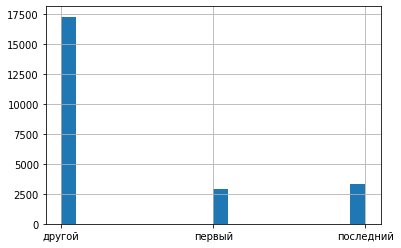

In [38]:
data['floor_type'].hist(bins = 20)

Можно заметить что квартир на первом этаже немного, на последнем чуть больше, но большая часть сосредоточена в категории "другой" так как этажи данного типа могут принимать намного больше значений чем первый или последний.

Рассмотрим общее количество этажей в доме:

<AxesSubplot:>

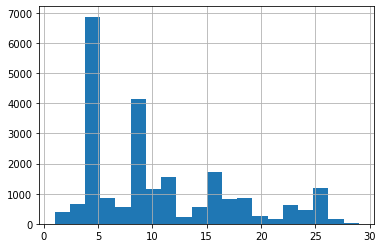

In [39]:
data['floors_total'].hist(bins = 20)

Такое распределение может быть связано с тем что большая часть домов разбивается на подвиды - хрущевки с 4-5 этажами, обычные дома которые имеют от 8-9 до 12-16 этажей. Остальные дома скорее всего частные и составляют небольшую долю от общего числа.

С этажами разобрались, перейдем к расстоянию до центра города:

<AxesSubplot:>

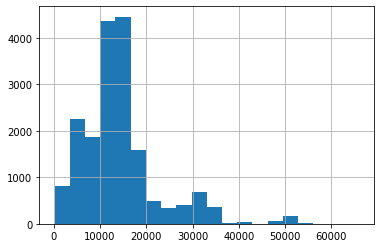

In [40]:
data['cityCenters_nearest'].hist(bins = 20)

Все вполне объяснимо - немного домов в центре города, далее в промежутке от 10км до 18км наибольшее число домов (жилые кварталы) и чем дальше от центра тем меньше квартир (чем дальше тем меньше плотность населенности и соответственно квартир)

Дальше расстояние до ближайшего аэропорта:

<AxesSubplot:>

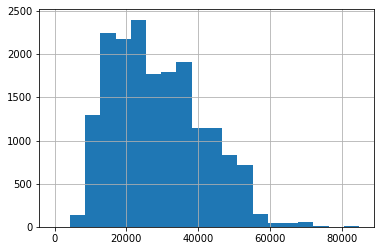

In [41]:
data['airports_nearest'].hist(bins = 20)

График напоминает нормальное распределение - нет домов на аэропорте, 
дальше количество увеличивается вплоть до промежутка от 18км до 37км, где находится наибольшая часть домов, и чем дальше тем меньше

Время посмотреть на расстояние до ближайшего парка:

<AxesSubplot:>

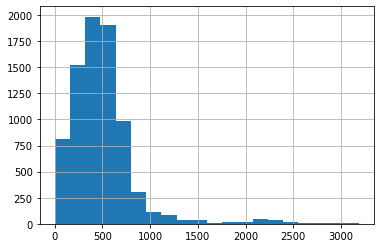

In [42]:
data['parks_nearest'].hist(bins = 20)

<AxesSubplot:>

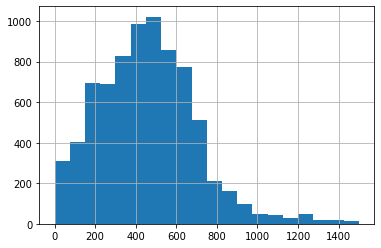

In [43]:
#рассмотрим в промежутке от 0 до 1500:
data['parks_nearest'].hist(bins = 20, range = (0,1500))

Получили нормальное распределение

Посмотрим как появлялись объявления по дням: (так как не указано по дням недели или дням месяцев, было принято решение указать
распределение по дням недели)

<AxesSubplot:>

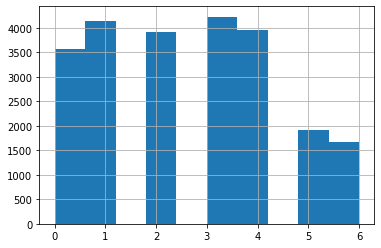

In [44]:
data['weekday'].hist()

Это говорит о том, что люди склонны выкладывать объявления в будни, тогда как в выходные активность сильно ниже

Посмотрим теперь на месяцы:

<AxesSubplot:>

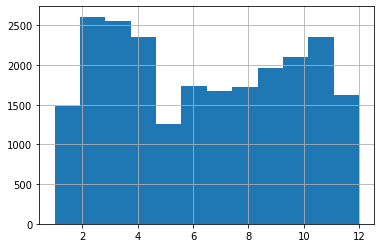

In [45]:
data['month'].hist(bins = 12)

Можно заметить, что в новогодние праздники (декабрь-январь) и начало лета (май-июнь) люди не так активно выкладывают объявления
Зато осенью и весной активность сильно возрастает.

### Длительность продаж

Рассмотрим, как быстро обычно продаются квартиры с помощью столбца `days_exposition`. Для этого рассчитаем медиану `median_days`, а также среднее значение `avg_days` в методе `describe()` и построим диаграмму размаха методом `boxplot`:

count    20308.000000
mean       180.141619
std        219.300437
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64


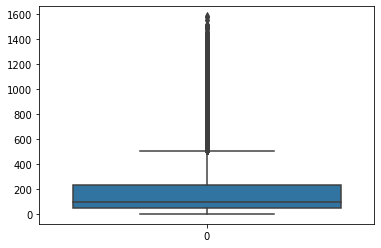

In [46]:
sb.boxplot(data=data['days_exposition'])
print(data['days_exposition'].describe())


Половина квартир продается за ~3 месяца(95 дней) а в среднем продажа занимает около 6 месяцев (180 дней). Для того чтобы понять, где примерно заканчивается верхний "ус" построим диаграмму в промежутке от 0 до 700:

[(0.0, 700.0)]

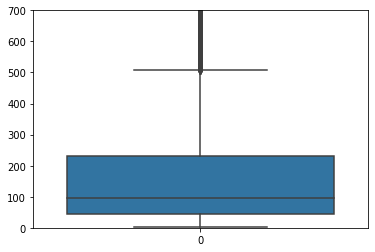

In [47]:
sb.boxplot(data=data['days_exposition']).set(ylim=(0,700))

Получили что верхняя граница "усов" примерно равна 520 дням, а значит все квартиры которые продаются дольше 520 дней - аномальные значения. Посмотрим какую часть от общей таблицы составляют такие аномалии:

In [48]:
print(data.query('days_exposition > 520').shape[0]/data.shape[0])

0.06809546172565427


Такие квартиры составляют всего 6% от всех продаж.

### Исследование факторов, влияющих на полную стоимость квартиры

Рассмотрим зависимость стоимости квартиры от общей площади. Для этого построим график и найдем коэф-т корреляции Пирсона:

Коэффициент корреляции: 0.6791981221987393


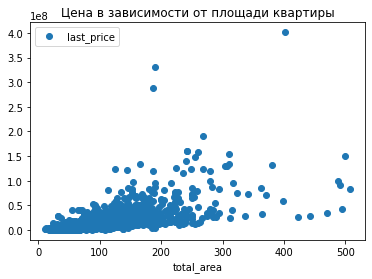

In [49]:
data.plot(x = 'total_area', y='last_price', style='o', title ='Цена в зависимости от площади квартиры')
print('Коэффициент корреляции:', data['total_area'].corr(data['last_price']))

Можно заметить, что в большинстве своем цена увеличивается при увеличении площади квартиры. Также значение коэф-та Пирсона ~0.67 говорит о том что корреляция положительная

Теперь рассмотрим зависимость от жилой площади:

Коэффициент корреляции: 0.5799406720482655


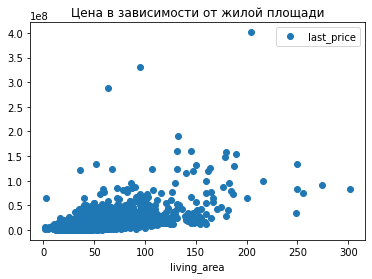

In [50]:
data.plot(x = 'living_area', y='last_price', style='o', title ='Цена в зависимости от жилой площади')
print('Коэффициент корреляции:', data['living_area'].corr(data['last_price']))

Также видим зависимость цены от жилой площади, что достаточно логично. Ведь жилая площадь напрямую зависит от общей площади, которая имеет положительную корреляцию со стоимостью.

Посмотрим связана ли цена с площадью кухни:

Коэффициент корреляции: 0.5091277908217713


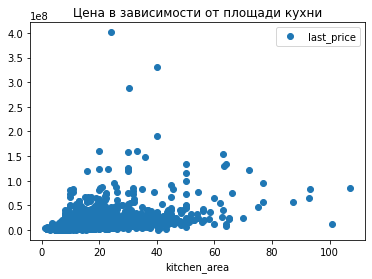

In [51]:
data.plot(x = 'kitchen_area', y='last_price', style='o', title ='Цена в зависимости от площади кухни')
print('Коэффициент корреляции:', data['kitchen_area'].corr(data['last_price']))

Здесь можно заметить, что стоимость не возрастает особо при увеличении площади кухни. Тогда можно сделать вывод, что площадь кухни - не самый приоритетный показатель при определении цены.

Взглянем на зависимость стоимости от количества комнат. Для этого стоит посчитать среднюю стоимость цены для каждого количества комнат и для полученных значений составить график:

<AxesSubplot:title={'center':'Цена в зависимости от количества комнат'}, xlabel='rooms'>

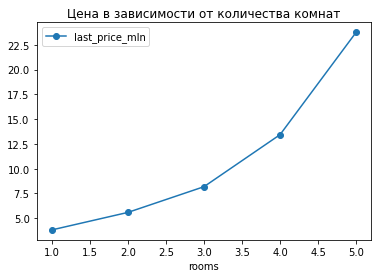

In [52]:
data['last_price_mln'] = data['last_price']/1000000 #для удобства введем цену выраженную в миллионах
(data.pivot_table(index = 'rooms', values = 'last_price_mln', aggfunc ='mean').
 plot(style ='o-', title ='Цена в зависимости от количества комнат')
)

Из графика видно что число комнат напрямую влияет на цену квартиры. 

Посмотрим зваисит ли цена от этажа квартиры:

<AxesSubplot:title={'center':'Цена по этажам'}, xlabel='floor_type'>

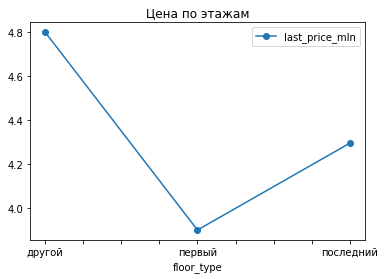

In [53]:
data.pivot_table(index = 'floor_type', values = 'last_price_mln', aggfunc='median').plot(style ='o-', title='Цена по этажам')

Из графика видно, что квартиры на первом этаже в среднем стоят дешевле чем квартиры на других этажах. 
Наибольшая средняя цена получилась для квартир которые находятся между первым и последним этажом. 


Теперь посмотрим связана ли цена с датой размещения. Сделаем несколько графиков - для года, месяцев и дней недели. В каждом случае рассчитаем медианную цену по месяцу/дню/году и будем сравнивать именно эти показатели (медиана чтобы исключить влияние очень дорогих и очень дешевых квартир):

<AxesSubplot:title={'center':'Средняя цена по годам'}, xlabel='year'>

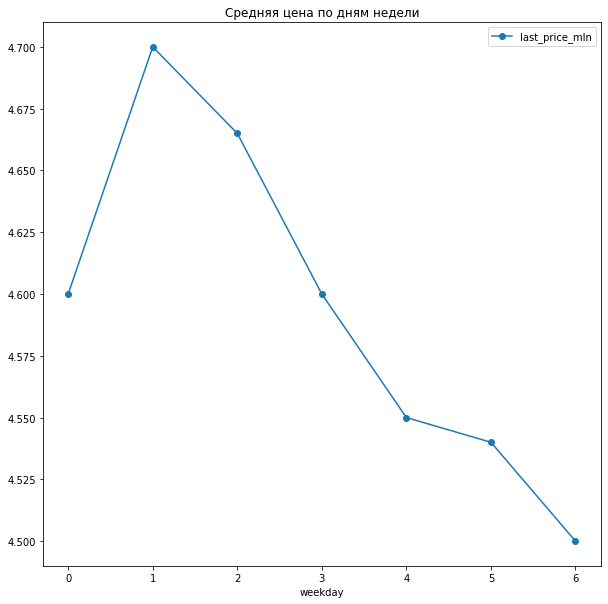

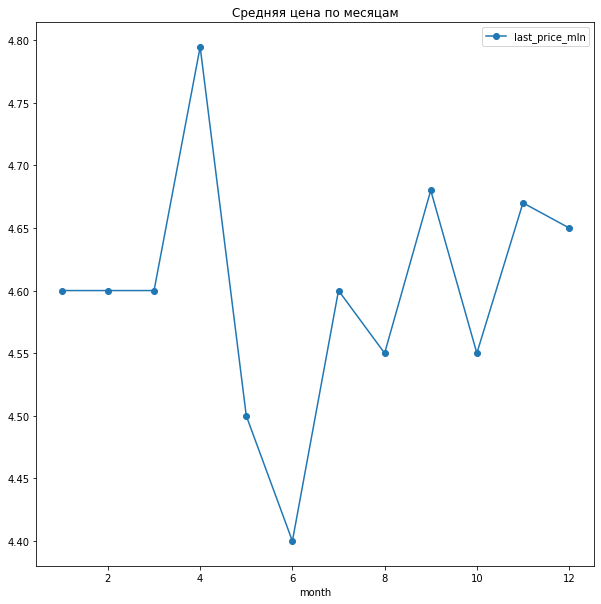

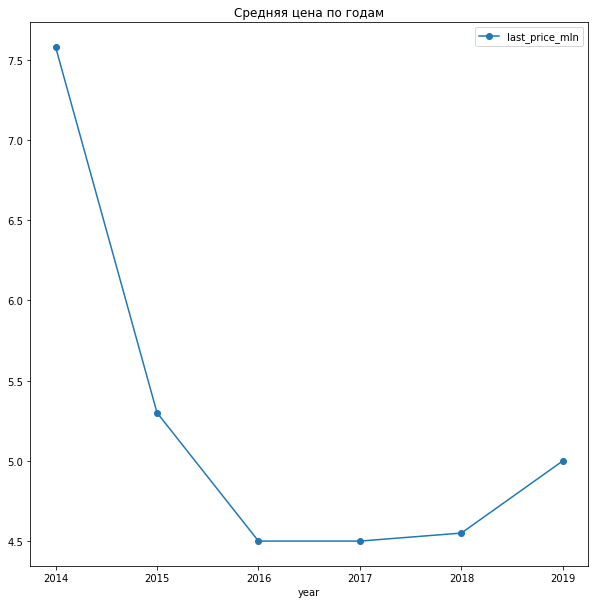

In [54]:
(data.
 pivot_table(index='weekday', values = 'last_price_mln', aggfunc='median').
 plot(style ='o-', figsize=(10,10), title='Средняя цена по дням недели')
)
(data.
 pivot_table(index='month', values = 'last_price_mln', aggfunc='median').
 plot(style ='o-', figsize=(10,10), title='Средняя цена по месяцам')
)
(data.
 pivot_table(index='year', values = 'last_price_mln', aggfunc='median').
 plot(style ='o-', figsize=(10,10), title='Средняя цена по годам')
)

- График для дней недели. В среднем цена высокая в начале недели но ближе к концу падает.
- График для месяцев. Виден заметный спад к началу лета и пик в апреле, однако в остальное время сложно сказать что есть конкретная зависимость цены от месяца.
- График для годов. А вот тут явно видна тенденция к уменьшению средней цены и лишь в последний год цена немного подросла. Как вариант такого поведения цены - в 2014 году был кризис на рынке недвижимости и цены были достаточно высокие, но после него ситуация с ценами стабилизировалась

### Анализ десяти населённых пунктов с наибольшим числом объявлений, анализ стоимости квадратного метра

In [55]:
#Сначала создадим Series объект top_cities чтобы выделить 10 самых населенных городов:
top_cities = data['locality_name'].value_counts().sort_values(ascending=False).head(10)


(data.query('locality_name in @top_cities.index').  #делаем срез по тем квартирам которые расположены в городах из top_cities
 pivot_table(index='locality_name', values = 'metre_price'). #создаем сводную таблицу где для каждого города считаем среднюю
 sort_values(by = 'metre_price',ascending=False).            #цену квадратного метра, далее сортируем по убыванию и выводим
 head(10)                                                    #полученную таблицу для городов:
)                                                            

,metre_price
locality_name,
санкт-петербург,114407.033438
пушкин,103221.059146
кудрово,95324.930544
парголово,90332.263023
мурино,86087.512050
шушары,78677.364217
колпино,75333.295801
гатчина,68746.146763
всеволожск,68654.473986


Получили что самая большая средняя цена за квадратный метр в Санкт-Петербурге, что достаточно логично, а вот наименьшая цена в Выборге.

### Анализ изменения цены квадратного метра в Санкт-Петербурге для каждого километра по степени удалённости от центра

Для начала создадим таблицу 

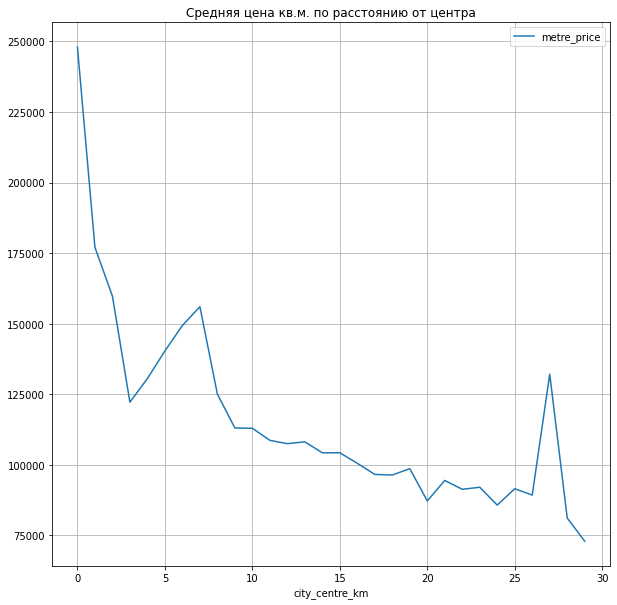

In [56]:
spb_data = data.query('locality_name == "санкт-петербург"') #создаем таблицу с квартирами из Санкт_Петербурга
(spb_data.pivot_table(index = 'city_centre_km', values = 'metre_price', aggfunc='mean').
 plot(figsize=(10,10), grid = True, title = 'Средняя цена кв.м. по расстоянию от центра') 
);

Можно заметить что средняя цена постепенно падает при отдалении от центра города. Однако присутствуют два "скачка" средней цены. Скорее всего они связаны с расположением квартир близко к какому-либо историческому памятнику или популярному месту, которые не расположены в центре.

## Общий вывод

В ходе исследования проверялось наличие зависимости между несколькими факторами:
- Зависимость цены квартиры от разных показателей
- Средний срок продажи квартиры
- Города с наибольшей средней стоимостью квадратного метра
- Зависимость стоимости квадратного метра от расстояния до центра в Санкт-Петербурге

Рассмотрим каждый пункт отдельно:

**1) Зависимость цены квартиры от разных показателей **

Было выявлено, что наиболее важные показатели для цены квартиры - это общая площадь и количество комнат, чем больше эти показатели тем выше цена. А вот дата публикации объявления никак не влияет на конечную цену продажи.

**2) Средний срок продажи квартир **

Большая часть квартир продается в срок от 1 месяца до 1 года, среднее время продажи - 6 месяцев. А вот продажи квартир занимающие больше 1 года являются необычайно долгими.

**3) Города с наибольшей стоимостью квадратного метра **

Было выделено 10 городов с наибольшим количеством объявлений. Среди них город с самой высокой средней стоимостью квадратного метра - Санкт-Петербург, а наименьшая стоимость квадратного метра в Выборге.

**4) Зависимость стоимости квадратного метра от расстояния до центра в Санкт-Петербурге**

Получена зависимост стоимости квадратного метра от расстояния до центра - средняя цена постепенно падает при отдалении от центра города. Однако присутствуют два "скачка" средней цены. Скорее всего они связаны с расположением квартир близко к какому-либо историческому памятнику или популярному месту, которые не расположены в центре.